# Problem 3 - Training a Small CNN

In [3]:
from __future__ import print_function, division
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torchvision
import shutil
import os
import pandas
import torch
import numpy as np
import time
import copy
import cv2
import json
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import normalize as norm
%matplotlib inline

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.cuda.get_device_name(0)

'Quadro RTX 5000 with Max-Q Design'

In [4]:
# Using GPU device
gpu_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Part 1

### Loading data

In [5]:
# Using the standard to load the CIFAR10 data
# Normalize data
cifar_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [6]:
# Load training data
cifar_trainset = torchvision.datasets.CIFAR10(root = "./cifar_data", train = True, download = True,
                                              transform = cifar_transform)
cifar_train_loader = torch.utils.data.DataLoader(cifar_trainset, batch_size = 64, shuffle = True, num_workers = 0)
# Load test data
cifar_testset = torchvision.datasets.CIFAR10(root = "./cifar_data", train = False, download = True,
                                              transform = cifar_transform)
cifar_test_loader = torch.utils.data.DataLoader(cifar_testset, batch_size = 64, shuffle = False, num_workers = 0)
# Type up the class names manually
cifar_names = ["Plane", "Car", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

Files already downloaded and verified
Files already downloaded and verified


### Create model

In [7]:
class cifar_cnn(nn.Module):
    def __init__(self):
        super(cifar_cnn, self).__init__()
        self.convlayer1 = nn.Conv2d(3, 64, 11)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.convlayer2 = nn.Conv2d(64, 128, 3)
        self.convlayer3 = nn.Conv2d(128, 128, 3)
        self.adaptivepool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(128, 10)
        
    def forward(self, x):
        out = F.relu(self.convlayer1(x))
        out = self.maxpool1(out)
        
        out = F.relu(self.convlayer2(out))
        
        out = F.relu(self.convlayer3(out))
        
        out = self.adaptivepool(out)
        
        out = out.view(-1, 128)

        out = self.fc1(out)
        
        return out

In [8]:
# Create model
cifar_model = cifar_cnn()
cifar_model.to(gpu_device)

cifar_cnn(
  (convlayer1): Conv2d(3, 64, kernel_size=(11, 11), stride=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convlayer2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (convlayer3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (adaptivepool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)

### Train model

In [1]:
# Train function taken from my own train function from question 2
def train_cifar(model, dataloader_train, dataloader_test, optimizer, criterion, num_epochs):    
    # Run all the epochs
    all_train_acc = []
    all_train_loss = []
    all_test_acc = []
    all_test_loss = []
    for epoch in range(num_epochs):
        # Run both train and test stage in each epoch
        dataset_sizes = {"train" : len(dataloader_train.dataset.data), "test" : len(dataloader_test.dataset.data)}
        if (epoch + 1) % 10 == 0:
            print("Epoch", str(epoch + 1), "/", str(num_epochs))
        for stage in ['train', 'test']:
            if stage == 'train':
                model.train()
                data_loader = dataloader_train
            else:
                model.eval()
                data_loader = dataloader_test
                
            run_correct = 0
            run_loss = 0.0
            
            # Load data from dataloader
            for i, data in enumerate(data_loader, 0):
                inputs, labels = data[0].to(gpu_device), data[1].to(gpu_device)

                optimizer.zero_grad()
                
                if stage == 'train':
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    print(preds)
                    loss = criterion(outputs, labels)

                    # Change weights in train stage
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                # Add to loss and accuracy
                run_correct += torch.sum(preds == labels.data)
                run_loss += loss.item()

            epoch_acc = run_correct.item() / dataset_sizes[stage]
            epoch_loss = run_loss / dataset_sizes[stage]
            
            if stage == 'train':
                all_train_acc.append(epoch_acc)
                all_train_loss.append(epoch_loss)
            else:
                all_test_acc.append(epoch_acc)
                all_test_loss.append(epoch_loss)

            if (epoch + 1) % 10 == 0:
                print(stage, "---", 'Accuracy: %.3f  Loss: %.3f' % (epoch_acc,  epoch_loss))

            run_loss = 0.0
            run_correct = 0
            
    return all_train_acc, all_train_loss, all_test_acc, all_test_loss

In [2]:
# Set the criterion
cross_entro = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
sgd = optim.SGD(cifar_model.parameters(), lr = 0.005, momentum = 0.8)

NameError: name 'nn' is not defined

In [21]:
# Train the model
cifar_train_acc, cifar_train_loss, cifar_test_acc, cifar_test_loss = train_cifar(cifar_model, cifar_train_loader,
                                                                                 cifar_test_loader, sgd, cross_entro, 200)

tensor([6, 0, 6, 0, 6, 6, 0, 6, 3, 3, 0, 6, 0, 0, 0, 6, 0, 0, 0, 0, 3, 0, 6, 6,
        0, 3, 6, 0, 0, 0, 6, 0, 0, 6, 0, 6, 0, 6, 3, 0, 6, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 6, 6, 6, 6, 6, 0, 6, 6, 3, 6], device='cuda:0')
tensor([0, 0, 0, 0, 0, 6, 0, 6, 6, 0, 0, 6, 6, 3, 6, 0, 0, 6, 6, 0, 0, 0, 0, 6,
        6, 0, 0, 0, 9, 6, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0, 6, 0, 6, 6, 6, 6, 3, 0,
        6, 0, 6, 0, 6, 0, 0, 9, 0, 3, 6, 6, 6, 0, 0, 0], device='cuda:0')
tensor([0, 6, 6, 6, 9, 0, 0, 0, 6, 3, 0, 0, 0, 0, 6, 6, 6, 0, 0, 6, 3, 0, 0, 6,
        3, 6, 6, 0, 0, 3, 0, 0, 3, 6, 0, 0, 6, 0, 6, 0, 0, 6, 0, 0, 6, 6, 6, 3,
        3, 0, 0, 0, 6, 0, 0, 6, 0, 6, 0, 0, 0, 6, 3, 6], device='cuda:0')
tensor([0, 6, 0, 6, 0, 0, 6, 0, 0, 0, 0, 6, 0, 9, 0, 6, 0, 0, 6, 0, 0, 0, 0, 6,
        0, 6, 9, 0, 6, 6, 6, 0, 0, 0, 6, 0, 0, 0, 9, 0, 0, 3, 3, 0, 0, 0, 3, 0,
        0, 9, 9, 0, 0, 3, 6, 9, 0, 6, 0, 6, 3, 3, 0, 3], device='cuda:0')
tensor([6, 6, 0, 6, 6, 6, 0, 0, 6, 0, 6, 0, 0, 0, 0, 0, 0, 0, 6,

tensor([6, 6, 9, 0, 6, 6, 1, 9, 6, 0, 6, 1, 9, 0, 6, 0, 0, 0, 0, 0, 1, 0, 6, 0,
        6, 6, 1, 6, 0, 6, 8, 0, 6, 8, 9, 0, 1, 0, 0, 6, 6, 5, 0, 6, 0, 6, 6, 7,
        6, 6, 6, 0, 6, 0, 0, 6, 0, 6, 6, 6, 0, 0, 0, 6], device='cuda:0')
tensor([6, 0, 1, 0, 6, 0, 0, 1, 6, 0, 6, 0, 0, 0, 6, 0, 6, 0, 0, 9, 6, 0, 0, 6,
        1, 0, 0, 0, 3, 0, 6, 0, 0, 0, 7, 6, 6, 0, 6, 7, 1, 8, 9, 6, 6, 1, 7, 6,
        9, 6, 6, 9, 0, 0, 6, 6, 6, 6, 1, 0, 6, 1, 6, 6], device='cuda:0')
tensor([1, 0, 6, 6, 6, 8, 6, 6, 6, 8, 0, 6, 3, 8, 6, 9, 1, 6, 1, 0, 6, 6, 0, 0,
        6, 6, 0, 6, 8, 0, 0, 6, 7, 6, 1, 6, 9, 5, 9, 6, 6, 0, 6, 1, 9, 0, 7, 0,
        9, 8, 6, 3, 8, 0, 1, 6, 6, 9, 8, 1, 6, 7, 0, 0], device='cuda:0')
tensor([0, 1, 1, 0, 9, 3, 8, 8, 6, 6, 6, 6, 6, 6, 8, 0, 6, 6, 1, 6, 0, 0, 6, 0,
        6, 6, 0, 8, 8, 6, 6, 9, 0, 6, 3, 6, 6, 6, 1, 8, 8, 6, 6, 1, 8, 6, 6, 8,
        8, 3, 6, 1, 1, 3, 0, 6, 6, 6, 1, 6, 0, 8, 0, 6], device='cuda:0')
tensor([1, 5, 0, 6, 8, 6, 9, 6, 6, 6, 6, 8, 9, 8, 1, 6, 6, 6, 1,

        6, 1, 1, 6, 6, 0, 6, 0, 0, 1, 6, 6, 0, 0, 0, 6], device='cuda:0')
tensor([8, 8, 8, 8, 6, 6, 0, 0, 1, 6, 0, 1, 6, 3, 6, 8, 6, 9, 6, 0, 8, 0, 6, 8,
        6, 0, 6, 0, 6, 6, 3, 0, 6, 1, 0, 1, 0, 3, 1, 6, 6, 6, 0, 6, 0, 1, 6, 6,
        6, 0, 3, 0, 0, 0, 9, 6, 6, 1, 6, 6, 8, 1, 6, 6], device='cuda:0')
tensor([6, 8, 6, 6, 0, 0, 8, 6, 8, 6, 1, 6, 8, 6, 9, 6, 1, 1, 9, 6, 9, 6, 6, 1,
        6, 6, 8, 6, 6, 9, 6, 6, 8, 6, 6, 6, 8, 8, 6, 0, 8, 8, 6, 6, 9, 6, 0, 1,
        6, 6, 0, 8, 6, 1, 6, 8, 6, 6, 6, 3, 6, 6, 8, 6], device='cuda:0')
tensor([8, 6, 6, 9, 9, 5, 8, 9, 1, 6, 6, 6, 6, 0, 6, 6, 0, 1, 6, 6, 8, 0, 9, 0,
        6, 9, 3, 9, 8, 6, 9, 6, 6, 6, 6, 1, 6, 8, 6, 5, 6, 9, 6, 6, 6, 6, 6, 8,
        0, 6, 6, 6, 6, 8, 7, 6, 6, 8, 8, 0, 7, 8, 1, 6], device='cuda:0')
tensor([6, 8, 8, 6, 8, 6, 8, 6, 6, 6, 9, 3, 6, 8, 6, 6, 8, 6, 3, 8, 8, 6, 6, 9,
        9, 6, 6, 8, 6, 6, 7, 6, 6, 6, 6, 6, 6, 6, 6, 0, 8, 8, 1, 6, 6, 6, 6, 6,
        9, 6, 0, 8, 8, 0, 7, 6, 6, 6, 8, 6, 8, 6, 6, 1], device=

tensor([1, 0, 7, 1, 1, 0, 1, 1, 6, 6, 7, 6, 6, 1, 7, 1, 6, 7, 6, 1, 6, 7, 6, 1,
        0, 5, 6, 1, 1, 6, 7, 1, 6, 0, 7, 6, 7, 6, 6, 0, 7, 0, 6, 0, 6, 6, 7, 7,
        6, 0, 6, 7, 6, 6, 0, 7, 6, 1, 7, 6, 7, 1, 6, 0], device='cuda:0')
tensor([0, 6, 7, 6, 6, 1, 1, 5, 7, 6, 6, 6, 7, 6, 1, 6, 3, 7, 6, 7, 7, 1, 6, 6,
        0, 1, 6, 1, 6, 6, 6, 1, 6, 0, 5, 0, 1, 0, 7, 6, 1, 7, 6, 7, 6, 6, 0, 1,
        6, 0, 1, 1, 1, 0, 7, 1, 6, 7, 7, 7, 1, 7, 1, 6], device='cuda:0')
tensor([1, 6, 7, 1, 1, 6, 1, 7, 1, 7, 6, 6, 7, 1, 7, 0, 1, 7, 1, 7, 6, 1, 7, 7,
        1, 7, 7, 6, 0, 0, 1, 1, 6, 0, 7, 7, 6, 7, 0, 0, 0, 1, 0, 7, 7, 7, 6, 6,
        6, 3, 7, 7, 1, 0, 0, 6, 1, 6, 0, 6, 7, 7, 6, 6], device='cuda:0')
tensor([0, 1, 6, 7, 0, 1, 6, 1, 6, 7, 1, 1, 0, 1, 0, 0, 1, 1, 7, 7, 1, 6, 0, 7,
        0, 7, 7, 7, 6, 0, 0, 7, 0, 0, 6, 7, 0, 0, 7, 0, 1, 0, 7, 6, 1, 0, 1, 1,
        7, 0, 0, 0, 7, 1, 7, 7, 6, 5, 1, 1, 7, 6, 1, 0], device='cuda:0')
tensor([7, 7, 7, 6, 7, 1, 6, 7, 7, 1, 1, 1, 6, 7, 6, 6, 1, 0, 1,

KeyboardInterrupt: 

### Save and load model

In [12]:
# Save the 4 arrays
store_acc_loss = pd.DataFrame({"train_acc": cifar_train_acc, "train_loss": cifar_train_loss,
                               "test_acc": cifar_test_acc, "test_loss": cifar_test_loss})
store_acc_loss.to_csv("question3_store.csv", index = False)

In [13]:
# Save model
torch.save(cifar_model.state_dict(), "./cifar_Q3.pth")

In [14]:
# # Load model
# cifar_model_loaded = cifar_cnn()
# cifar_model_loaded.load_state_dict(torch.load("./cifar_Q3.pth"))

### IMAGE SHOWING THE FILTERS

In [32]:
def imshow_layer(layer, title_t):
    number_filters = len(layer.weight)
    
    fig = plt.figure(figsize=(12, 28))
    _ = plt.title(title_t)
    _ = plt.axis('off')
    
    for i in range(number_filters):
        p = i + 1
        
        axes = fig.add_subplot(number_filters//6 + 1, 6, p)
        
        std_correction = np.asarray([0.229, 0.224, 0.225]).reshape(3, 1, 1)
        mean_correction = np.asarray([0.485, 0.456, 0.406]).reshape(3, 1, 1)
        fixed_img = np.multiply(layer.weight.cpu().detach().numpy()[i], std_correction) + mean_correction
        
        plt.imshow(np.transpose(fixed_img, (1, 2, 0)))
        
        axes.title.set_text(p)

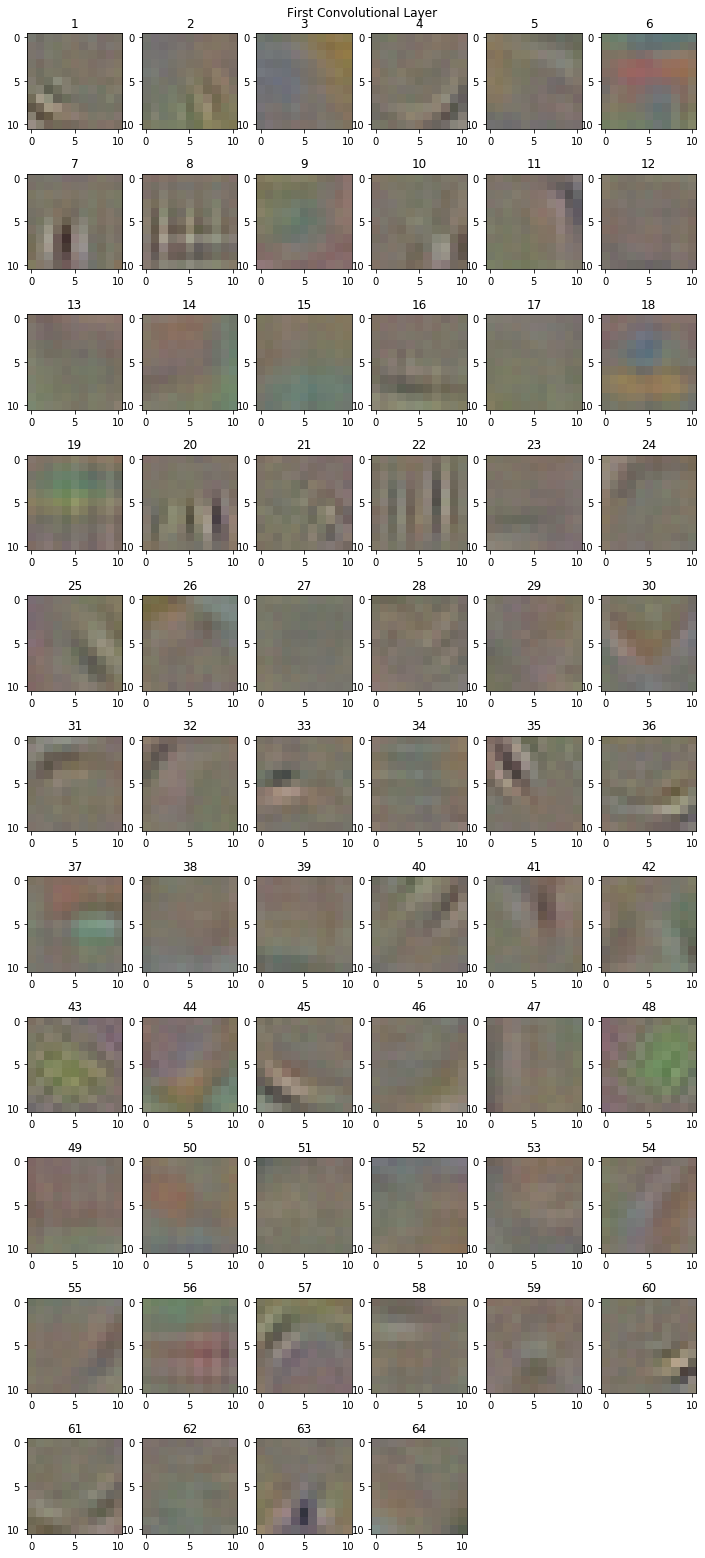

In [33]:
imshow_layer(cifar_model.convlayer1, "First Convolutional Layer")

### TRAINING LOSS AS FUNCTION OF EPOCHS

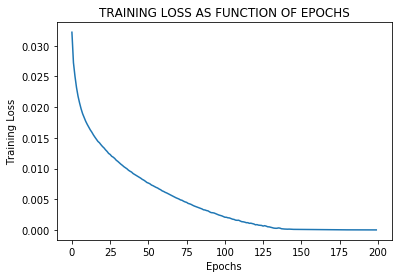

In [23]:
_ = plt.plot(np.arange(len(cifar_train_loss)), cifar_train_loss)
_ = plt.title("TRAINING LOSS AS FUNCTION OF EPOCHS")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Training Loss")

### TEST DATA ACCURACY

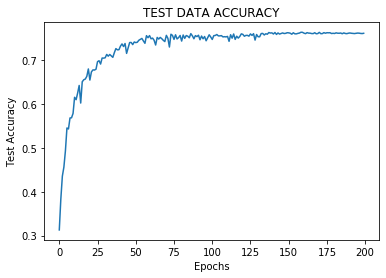

In [25]:
plt.plot(np.arange(len(cifar_test_acc)), cifar_test_acc)
_ = plt.title("TEST DATA ACCURACY")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Test Accuracy")

### WEIGHT INITIALIZATION INFORMATION

I used the pytorch default weight initializer. It is basically a random uniform of the standard deviation of the data negative to positive

### DESCRIBE HYPER-PARAMETERS

Used SGD, learning rate = 0.05 and momentum = 0.8

## Part 2

### Create Norm Model

In [36]:
# Add in batch normalization
class cifar_cnn_batch(nn.Module):
    def __init__(self):
        super(cifar_cnn_batch, self).__init__()
        self.convlayer1 = nn.Conv2d(3, 64, 11)
        self.convlayer1_b = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.convlayer2 = nn.Conv2d(64, 128, 3)
        self.convlayer2_b = nn.BatchNorm2d(128)
        self.convlayer3 = nn.Conv2d(128, 128, 3)
        self.convlayer3_b = nn.BatchNorm2d(128)
        self.adaptivepool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(128, 10)
        
    def forward(self, x):
        out = F.relu(self.convlayer1_b(self.convlayer1(x)))
        out = self.maxpool1(out)
        
        out = F.relu(self.convlayer2_b(self.convlayer2(out)))
        
        out = F.relu(self.convlayer3_b(self.convlayer3(out)))
        
        out = self.adaptivepool(out)
        
        out = out.view(-1, 128)

        out = self.fc1(out)
        
        return out

In [37]:
# Create model
cifar_model_batch = cifar_cnn_batch()
cifar_model_batch.to(gpu_device)

cifar_cnn_batch(
  (convlayer1): Conv2d(3, 64, kernel_size=(11, 11), stride=(1, 1))
  (convlayer1_b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convlayer2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (convlayer2_b): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convlayer3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (convlayer3_b): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (adaptivepool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=128, out_features=10, bias=True)
)

### Train model

In [39]:
# Set the criterion
cross_entro = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
sgd_batch = optim.SGD(cifar_model_batch.parameters(), lr = 0.005, momentum = 0.8)

In [40]:
# Train the model
cifar_train_acc_batch, cifar_train_loss_batch, cifar_test_acc_batch, cifar_test_loss_batch = train_cifar(cifar_model_batch,
                                                                                                         cifar_train_loader,
                                                                                                         cifar_test_loader,
                                                                                                         sgd_batch,
                                                                                                         cross_entro, 200)

Epoch 10 / 200
train --- Accuracy: 0.728  Loss: 0.012
test --- Accuracy: 0.695  Loss: 0.014
Epoch 20 / 200
train --- Accuracy: 0.803  Loss: 0.009
test --- Accuracy: 0.728  Loss: 0.012
Epoch 30 / 200
train --- Accuracy: 0.849  Loss: 0.007
test --- Accuracy: 0.761  Loss: 0.011
Epoch 40 / 200
train --- Accuracy: 0.884  Loss: 0.005
test --- Accuracy: 0.763  Loss: 0.011
Epoch 50 / 200
train --- Accuracy: 0.913  Loss: 0.004
test --- Accuracy: 0.771  Loss: 0.011
Epoch 60 / 200
train --- Accuracy: 0.936  Loss: 0.003
test --- Accuracy: 0.776  Loss: 0.011
Epoch 70 / 200
train --- Accuracy: 0.955  Loss: 0.002
test --- Accuracy: 0.780  Loss: 0.012
Epoch 80 / 200
train --- Accuracy: 0.969  Loss: 0.002
test --- Accuracy: 0.778  Loss: 0.013
Epoch 90 / 200
train --- Accuracy: 0.978  Loss: 0.001
test --- Accuracy: 0.780  Loss: 0.013
Epoch 100 / 200
train --- Accuracy: 0.983  Loss: 0.001
test --- Accuracy: 0.775  Loss: 0.014
Epoch 110 / 200
train --- Accuracy: 0.988  Loss: 0.001
test --- Accuracy: 0.775

In [41]:
# Save the 4 arrays
store_acc_loss_batch = pd.DataFrame({"train_acc": cifar_train_acc_batch, "train_loss": cifar_train_loss_batch,
                               "test_acc": cifar_test_acc_batch, "test_loss": cifar_test_loss_batch})
store_acc_loss_batch.to_csv("question3_store_batch.csv", index = False)

In [42]:
# Save model
torch.save(cifar_model_batch.state_dict(), "./cifar_Q3_batch.pth")

### Compare the training loss

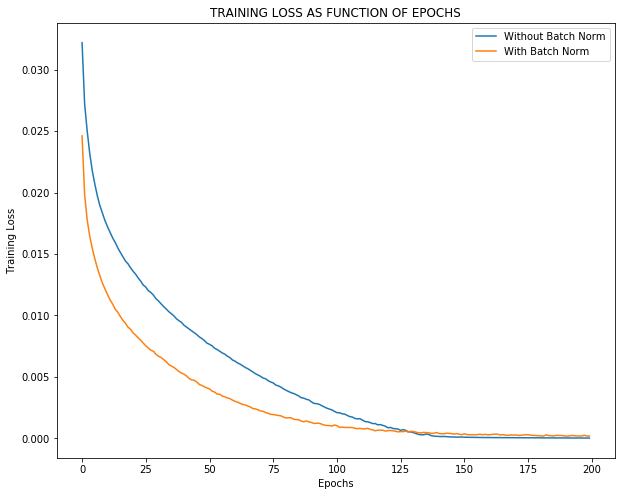

In [46]:
_ = plt.figure(figsize = (10, 8))
_ = plt.plot(np.arange(len(cifar_train_loss)), cifar_train_loss)
_ = plt.plot(np.arange(len(cifar_train_loss_batch)), cifar_train_loss_batch)
_ = plt.title("TRAINING LOSS AS FUNCTION OF EPOCHS")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Training Loss")
_ = plt.legend(["Without Batch Norm", "With Batch Norm"])

### Visualize Filters

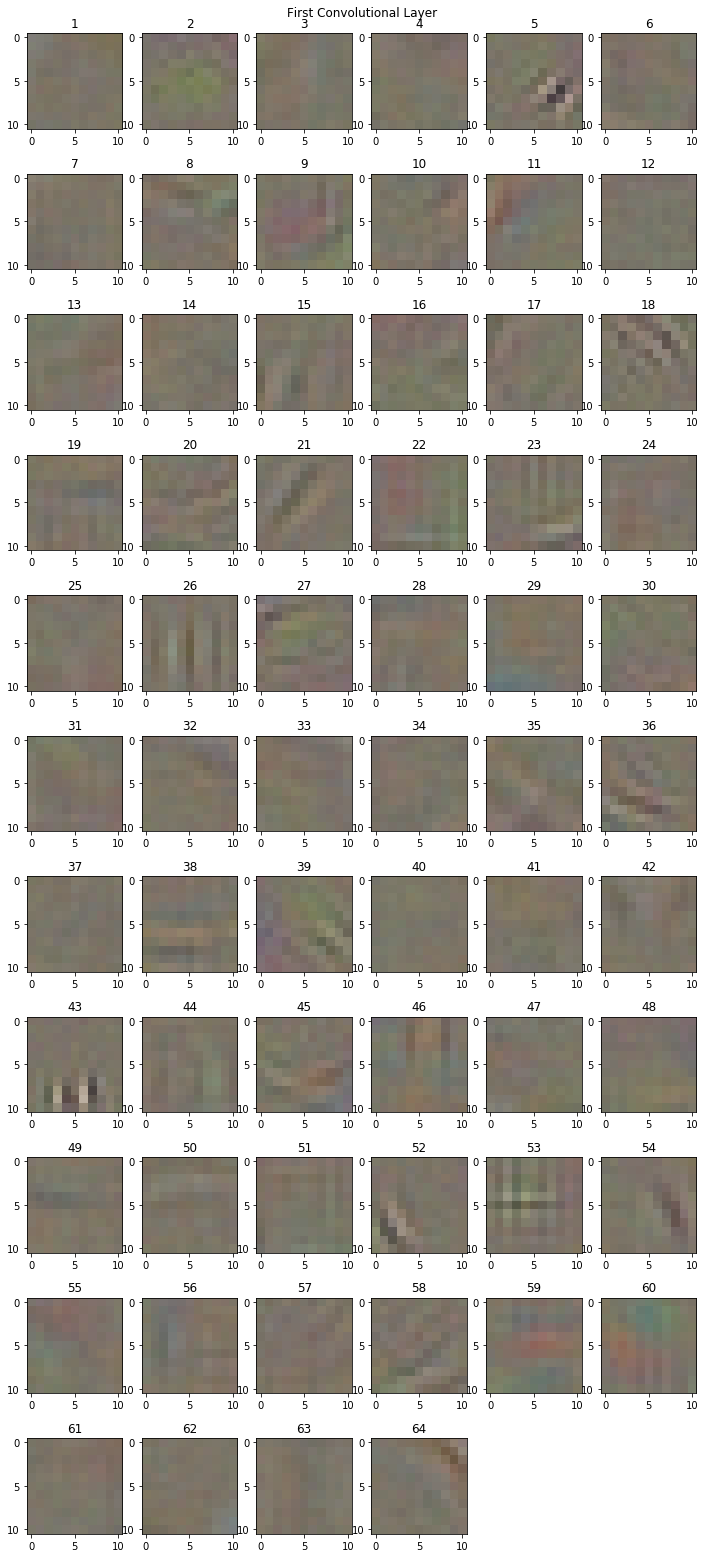

In [47]:
imshow_layer(cifar_model_batch.convlayer1, "First Convolutional Layer")

## Part 3

### Create deeper model

In [55]:
# Add in batch normalization
class cifar_cnn_mine(nn.Module):
    def __init__(self):
        super(cifar_cnn_mine, self).__init__()
        self.convlayer1 = nn.Conv2d(3, 64, 3)
        self.convlayer1_b = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout2d(0.3)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.convlayer2 = nn.Conv2d(64, 128, 3)
        self.convlayer2_b = nn.BatchNorm2d(128)
        self.dropout2 = nn.Dropout2d(0.3)
        self.convlayer3 = nn.Conv2d(128, 128, 3)
        self.convlayer3_b = nn.BatchNorm2d(128)
        self.dropout3 = nn.Dropout2d(0.25)
        self.convlayer4 = nn.Conv2d(128, 256, 3)
        self.convlayer4_b = nn.BatchNorm2d(256)
        self.dropout4 = nn.Dropout2d(0.2)
        self.adaptivepool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 128)
        self.dropout5 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 10)
        
    def forward(self, x):
        out = F.relu(self.convlayer1_b(self.convlayer1(x)))
        out = self.dropout1(out)
        
        out = self.maxpool1(out)
        
        out = F.relu(self.convlayer2_b(self.convlayer2(out)))
        out = self.dropout2(out)
        
        out = F.relu(self.convlayer3_b(self.convlayer3(out)))
        out = self.dropout3(out)
        
        out = F.relu(self.convlayer4_b(self.convlayer4(out)))
        out = self.dropout4(out)
        
        out = self.adaptivepool(out)
        
        out = out.view(-1, 256)

        out = self.fc1(out)
        out = self.dropout5(out)
        
        out = self.fc2(out)
        
        return out

In [56]:
# Create model
cifar_model_mine = cifar_cnn_mine()
cifar_model_mine.to(gpu_device)

cifar_cnn_mine(
  (convlayer1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (convlayer1_b): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (convlayer2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (convlayer2_b): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout2d(p=0.3, inplace=False)
  (convlayer3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (convlayer3_b): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout3): Dropout2d(p=0.25, inplace=False)
  (convlayer4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (convlayer4_b): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout4): Dropout2d(p=0.2, inplace=False)
  (adaptivepool): AdaptiveAvgPool2d(output_size

### Train my model

In [57]:
# Set the criterion
cross_entro = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
sgd_mine = optim.SGD(cifar_model_mine.parameters(), lr = 0.005, momentum = 0.8)

In [58]:
# Train the model
cifar_train_acc_mine, cifar_train_loss_mine, cifar_test_acc_mine, cifar_test_loss_mine = train_cifar(cifar_model_mine,
                                                                                                         cifar_train_loader,
                                                                                                         cifar_test_loader,
                                                                                                         sgd_mine,
                                                                                                         cross_entro, 200)

Epoch 10 / 200
train --- Accuracy: 0.565  Loss: 0.019
test --- Accuracy: 0.636  Loss: 0.016
Epoch 20 / 200
train --- Accuracy: 0.642  Loss: 0.016
test --- Accuracy: 0.729  Loss: 0.012
Epoch 30 / 200
train --- Accuracy: 0.689  Loss: 0.014
test --- Accuracy: 0.759  Loss: 0.011
Epoch 40 / 200
train --- Accuracy: 0.718  Loss: 0.013
test --- Accuracy: 0.789  Loss: 0.010
Epoch 50 / 200
train --- Accuracy: 0.741  Loss: 0.012
test --- Accuracy: 0.800  Loss: 0.009
Epoch 60 / 200
train --- Accuracy: 0.760  Loss: 0.011
test --- Accuracy: 0.809  Loss: 0.009
Epoch 70 / 200
train --- Accuracy: 0.775  Loss: 0.010
test --- Accuracy: 0.826  Loss: 0.008
Epoch 80 / 200
train --- Accuracy: 0.785  Loss: 0.010
test --- Accuracy: 0.829  Loss: 0.008
Epoch 90 / 200
train --- Accuracy: 0.796  Loss: 0.009
test --- Accuracy: 0.834  Loss: 0.008
Epoch 100 / 200
train --- Accuracy: 0.800  Loss: 0.009
test --- Accuracy: 0.827  Loss: 0.008
Epoch 110 / 200
train --- Accuracy: 0.811  Loss: 0.009
test --- Accuracy: 0.836

In [59]:
# Save the 4 arrays
store_acc_loss_mine = pd.DataFrame({"train_acc": cifar_train_acc_mine, "train_loss": cifar_train_loss_mine,
                               "test_acc": cifar_test_acc_mine, "test_loss": cifar_test_loss_mine})
store_acc_loss_mine.to_csv("question3_store_mine.csv", index = False)

In [60]:
# Save model
torch.save(cifar_model_mine.state_dict(), "./cifar_Q3_mine.pth")

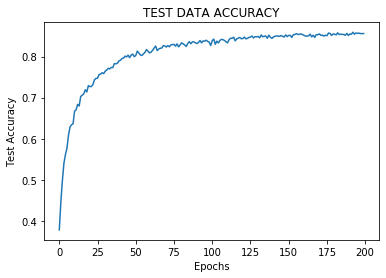

In [61]:
plt.plot(np.arange(len(cifar_test_acc_mine)), cifar_test_acc_mine)
_ = plt.title("TEST DATA ACCURACY")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Test Accuracy")